In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/TemperatureRainFall (1).csv')

In [ ]:
data.head()

,Date,MinTemp,MaxTemp,9amTemp,3pmTemp,Rainfall
0,01/12/2008,13.4,22.9,16.9,21.8,0.6
1,02/12/2008,7.4,25.1,17.2,24.3,0.0
2,03/12/2008,12.9,25.7,21.0,23.2,0.0
3,04/12/2008,9.2,28.0,18.1,26.5,0.0
4,05/12/2008,17.5,32.3,17.8,29.7,1.0


In [ ]:
data.tail()

,Date,MinTemp,MaxTemp,9amTemp,3pmTemp,Rainfall
3006,21/06/2017,1.2,15.2,2.9,14.3,0.4
3007,22/06/2017,0.8,13.4,3.6,13.3,0.0
3008,23/06/2017,1.1,11.9,2.7,10.2,0.0
3009,24/06/2017,1.1,14.1,3.9,13.1,0.2
3010,25/06/2017,3.9,10.9,6.4,8.8,0.0


In [ ]:
data.isnull().sum()

,0
Date,0
MinTemp,6
MaxTemp,1
9amTemp,4
3pmTemp,4
Rainfall,20


In [ ]:
data = data.fillna(method='ffill')

<ipython-input-7-449dda89d9c2>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


**Data preprocessing**

In [ ]:
# Separate features and targets
X = data.drop(columns=['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp', 'Rainfall'])
y = data[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp', 'Rainfall']]

In [ ]:
# Converting data to time series
def create_sequences(data, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data.iloc[i:i+seq_length].values)
        y_seq.append(data.iloc[i+seq_length].values)
    return np.array(X_seq), np.array(y_seq)

seq_length = 30  # 30 Days of sequence
X_seq, y_seq = create_sequences(data, seq_length)

In [ ]:
# Divide the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
print(data.dtypes)

Date         object
MinTemp     float64
MaxTemp     float64
9amTemp     float64
3pmTemp     float64
Rainfall    float64
dtype: object


In [ ]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
X = data[numeric_columns]

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data = data.drop(columns=['Date'])

In [ ]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
X = data[numeric_columns]

y = data[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp', 'Rainfall']]

def create_sequences(data, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data.iloc[i:i+seq_length].values)
        y_seq.append(y.iloc[i+seq_length].values)
    return np.array(X_seq), np.array(y_seq)

seq_length = 30
X_seq, y_seq = create_sequences(X, seq_length)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

**Build Model**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate

# Input Layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM Layers
lstm_layer_1 = LSTM(100, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
dropout_layer_1 = Dropout(0.3)(lstm_layer_1)
lstm_layer_2 = LSTM(100, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_layer_1)
dropout_layer_2 = Dropout(0.3)(lstm_layer_2)

# Output Layers
output_min_temp = Dense(1, name='MinTemp')(dropout_layer_2)
output_max_temp = Dense(1, name='MaxTemp')(dropout_layer_2)
output_9am_temp = Dense(1, name='9amTemp')(dropout_layer_2)
output_3pm_temp = Dense(1, name='3pmTemp')(dropout_layer_2)
output_rainfall = Dense(1, name='Rainfall')(dropout_layer_2)

# Create Model
model = Model(inputs=input_layer, outputs=[output_min_temp, output_max_temp, output_9am_temp, output_3pm_temp, output_rainfall])

In [ ]:
# Compile Model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 30, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 30, 100)        │         43,600 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 30, 100)        │              0 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 100)            │         80,400 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 100)            │              0 │ lstm_7[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MinTemp (Dense)           │ (None, 1)              │            101 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MaxTemp (Dense)           │ (None, 1)              │            101 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 9amTemp (Dense)           │ (None, 1)              │            101 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 3pmTemp (Dense)           │ (None, 1)              │            101 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Rainfall (Dense)          │ (None, 1)              │            101 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 124,505 (486.35 KB)

 Trainable params: 124,505 (486.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10) # Stop if val_loss doesn't improve for 10 epochs

# Training the model
history = model.fit(
    X_train,
    {'MinTemp': y_train[:, 0], 'MaxTemp': y_train[:, 1], '9amTemp': y_train[:, 2], '3pmTemp': y_train[:, 3], 'Rainfall': y_train[:, 4]},
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - 3pmTemp_loss: 77.9076 - 9amTemp_loss: 356.7808 - MaxTemp_loss: 147.7646 - MinTemp_loss: 300.4088 - Rainfall_loss: 49.4024 - loss: 934.0956 - val_3pmTemp_loss: 35.0765 - val_9amTemp_loss: 84.0179 - val_MaxTemp_loss: 39.9548 - val_MinTemp_loss: 69.3400 - val_Rainfall_loss: 51.5602 - val_loss: 282.5901
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - 3pmTemp_loss: 28.4842 - 9amTemp_loss: 63.8794 - MaxTemp_loss: 29.9504 - MinTemp_loss: 52.1675 - Rainfall_loss: 37.3862 - loss: 213.7918 - val_3pmTemp_loss: 16.2070 - val_9amTemp_loss: 31.1174 - val_MaxTemp_loss: 15.8468 - val_MinTemp_loss: 26.9656 - val_Rainfall_loss: 51.3257 - val_loss: 144.0073
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - 3pmTemp_loss: 16.6100 - 9amTemp_loss: 29.1808 - MaxTemp_loss: 14.6487 - MinTemp_loss: 25.4588 - Rainfall_loss: 46.7091 - loss: 134.5406 - val_3pmTemp_loss: 12.2207 - val_9amTemp_loss: 18.9557 - val_MaxTemp_loss: 10.4507 - val_MinTe

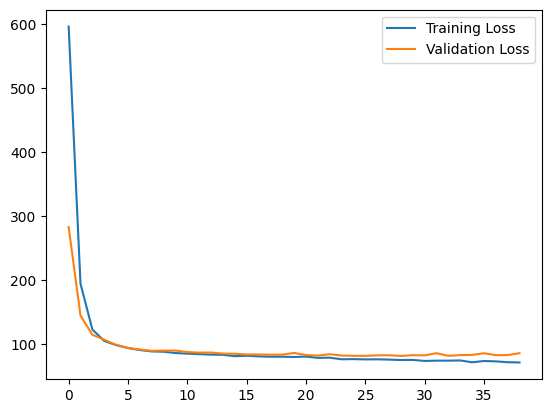

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert y_pred from a list of arrays to a 2D array
y_pred = np.concatenate(y_pred, axis=1)  # Concatenate predictions for all target variables

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 8.355803188995104, RMSE: 9.702429759754045


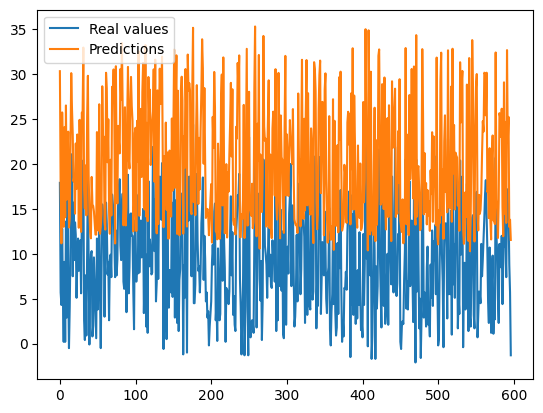

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test[:, 0], label='Real values')
plt.plot(y_pred[:, 0], label='Predictions')
plt.legend()
plt.show()